In [1]:
# load data
import numpy as np
train_file = np.load('data/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('data/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)


train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Assume training_data is loaded and has shape (10000, 50, 110, 6)
# Example: training_data = np.load('your_training_data.npy')

def compute_non_zero_percentage(training_data):
    # Extract position_x and position_y -> shape becomes (10000, 50, 110, 2)
    positions = training_data[:, :, :, :2]

    # Create a mask where both position_x and position_y are 0
    zero_mask = np.all(positions == 0, axis=-1)  # shape: (10000, 50, 110)

    # Count how many time steps are non-zero (i.e., not padded) per agent
    non_zero_counts = (~zero_mask).sum(axis=(0, 2))  # shape: (50,)

    # Total number of time steps per agent across all scenes = 10000 * 110
    total_time_steps = training_data.shape[0] * training_data.shape[2]  # 10000 * 110

    # Compute percentage of non-zero data
    non_zero_percentage = (non_zero_counts / total_time_steps) * 100  # shape: (50,)

    return non_zero_percentage

def plot_non_zero_percentages(non_zero_percentage):
    agents = np.arange(len(non_zero_percentage))  # 0 to 49
    plt.figure(figsize=(12, 6))
    plt.bar(agents, non_zero_percentage, color='skyblue')
    plt.xlabel('Agent Number')
    plt.ylabel('Percentage of Non-Zero Position Data')
    plt.title('Non-Zero (Unpadded) Data Percentage Per Agent')
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(agents)
    plt.tight_layout()
    plt.show()



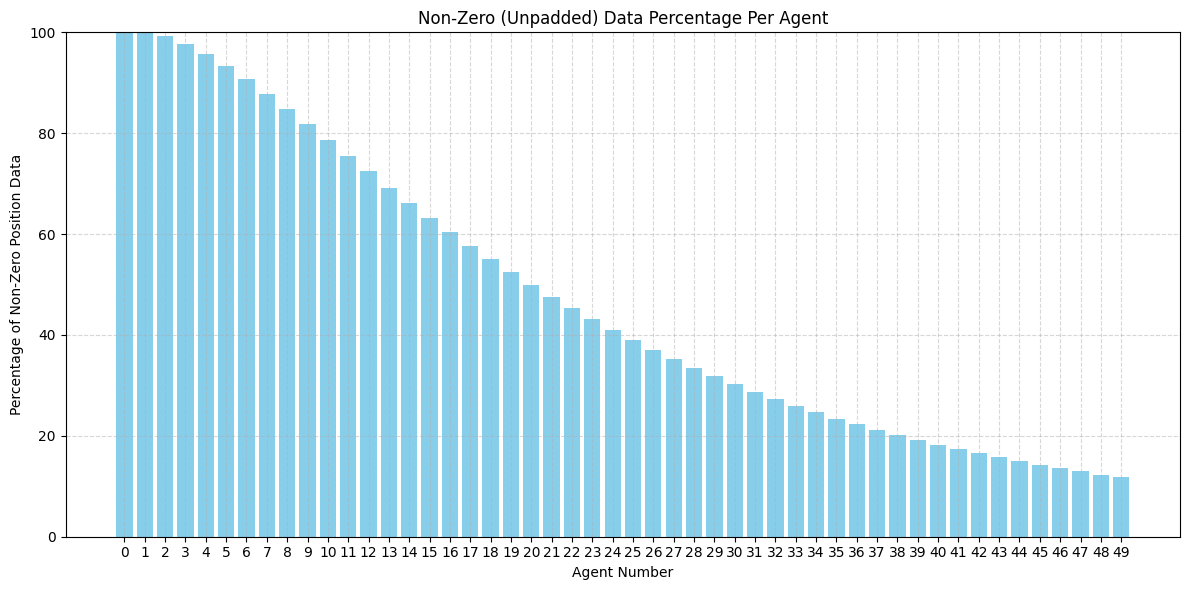

In [3]:
non_zero_percentage = compute_non_zero_percentage(train_data)
plot_non_zero_percentages(non_zero_percentage)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compute_position_variance(training_data):
    # Extract position_x and position_y (shape: 10000, 50, 110, 2)
    positions = training_data[:, :, :, :2]

    # Create a mask to ignore padded positions (0,0)
    non_zero_mask = np.any(positions != 0, axis=-1)  # shape: (10000, 50, 110)

    # Initialize list to hold variance per agent
    agent_variances = []

    for agent_idx in range(training_data.shape[1]):  # 50 agents
        # Get all (x, y) positions for this agent across scenes and timesteps
        agent_positions = positions[:, agent_idx, :, :]  # shape: (10000, 110, 2)
        agent_mask = non_zero_mask[:, agent_idx, :]     # shape: (10000, 110)

        # Flatten only the valid (non-zero) positions
        valid_positions = agent_positions[agent_mask]   # shape: (N_valid, 2)

        if valid_positions.shape[0] > 0:
            # Compute variance of x and y separately, then average
            var_x = np.var(valid_positions[:, 0])
            var_y = np.var(valid_positions[:, 1])
            agent_variances.append((var_x + var_y) / 2)
        else:
            # If all values are padded, assign variance as 0
            agent_variances.append(0.0)

    return np.array(agent_variances)

def plot_agent_variances(agent_variances):
    agents = np.arange(len(agent_variances))
    plt.figure(figsize=(12, 6))
    plt.bar(agents, agent_variances, color='lightgreen')
    plt.xlabel('Agent Number')
    plt.ylabel('Average Variance in Position (x & y)')
    plt.title('Average Positional Variance Per Agent (Non-Zero Data Only)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(agents)
    plt.tight_layout()
    plt.show()




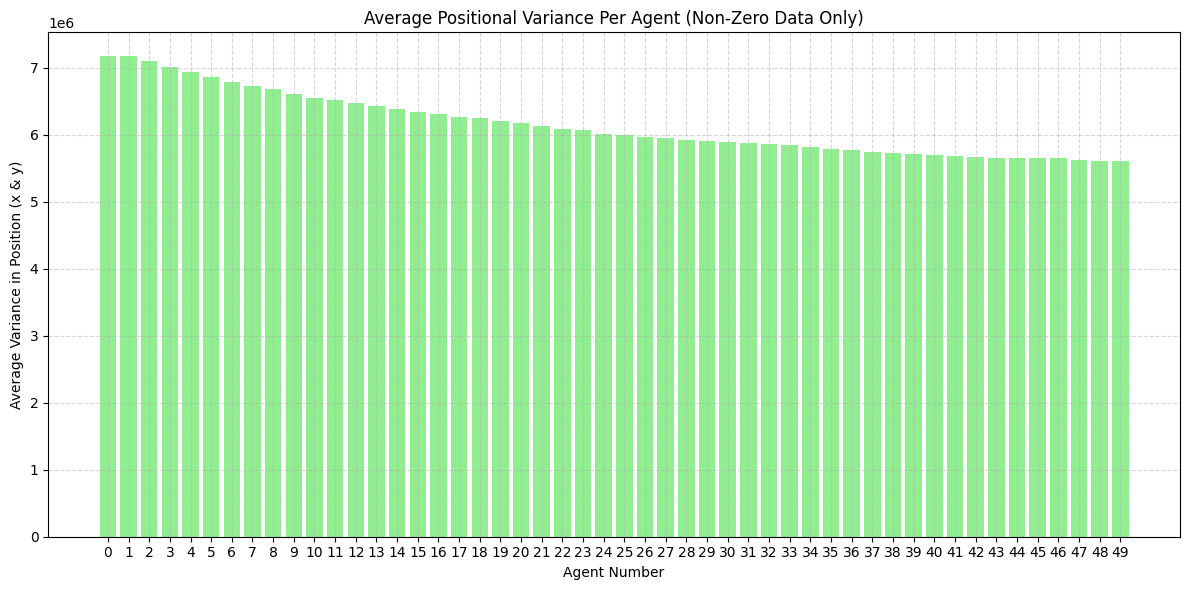

In [5]:
agent_variances = compute_position_variance(train_data)
plot_agent_variances(agent_variances)

In [6]:
import numpy as np

def compute_avg_trajectory_length(training_data):
    """
    Returns average trajectory length (non-zero x and y timesteps) per agent.
    """
    # Extract position_x and position_y
    positions = training_data[:, :, :, :2]  # shape: (10000, 50, 110, 2)

    # Non-zero mask where (x, y) is not both 0
    non_zero_mask = np.any(positions != 0, axis=-1)  # shape: (10000, 50, 110)

    # Count non-zero time steps per agent per scene
    traj_lengths = non_zero_mask.sum(axis=2)  # shape: (10000, 50)

    # Average over all 10,000 scenes
    avg_traj_lengths = traj_lengths.mean(axis=0)  # shape: (50,)

    return avg_traj_lengths


In [7]:
import matplotlib.pyplot as plt

def plot_bar(data, title, ylabel, color='skyblue'):
    agents = np.arange(len(data))
    plt.figure(figsize=(12, 6))
    plt.bar(agents, data, color=color)
    plt.xlabel('Agent Number')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(agents)
    plt.tight_layout()
    plt.show()


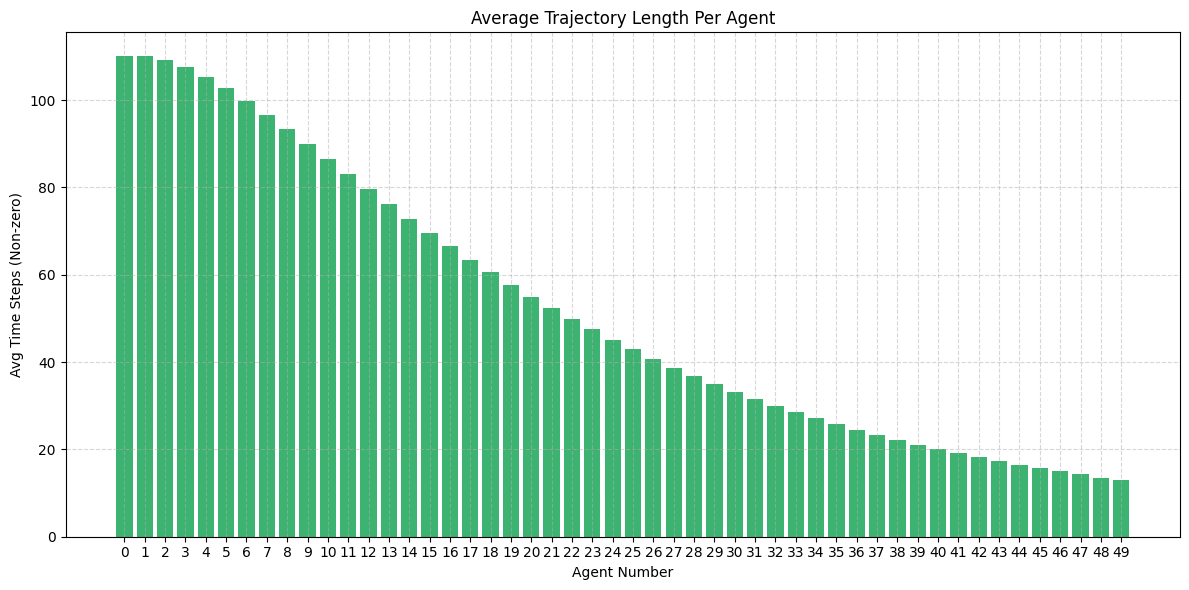

In [8]:
avg_traj_lengths = compute_avg_trajectory_length(train_data)
plot_bar(avg_traj_lengths, 'Average Trajectory Length Per Agent', 'Avg Time Steps (Non-zero)', 'mediumseagreen')

In [9]:
def compute_avg_speed(training_data):
    """
    Returns average speed per agent (ignoring padded timesteps).
    """
    # Extract velocities (vx, vy)
    velocities = training_data[:, :, :, 2:4]  # shape: (10000, 50, 110, 2)
    positions = training_data[:, :, :, :2]    # needed to mask padded steps

    # Compute speed = √(vx² + vy²)
    speed = np.linalg.norm(velocities, axis=-1)  # shape: (10000, 50, 110)

    # Mask out padded timesteps (where x and y == 0)
    non_zero_mask = np.any(positions != 0, axis=-1)  # shape: (10000, 50, 110)
    speed[~non_zero_mask] = np.nan  # Mask out padded entries

    # Average speed per agent, ignoring NaNs
    avg_speeds = np.nanmean(speed, axis=(0, 2))  # shape: (50,)

    return avg_speeds


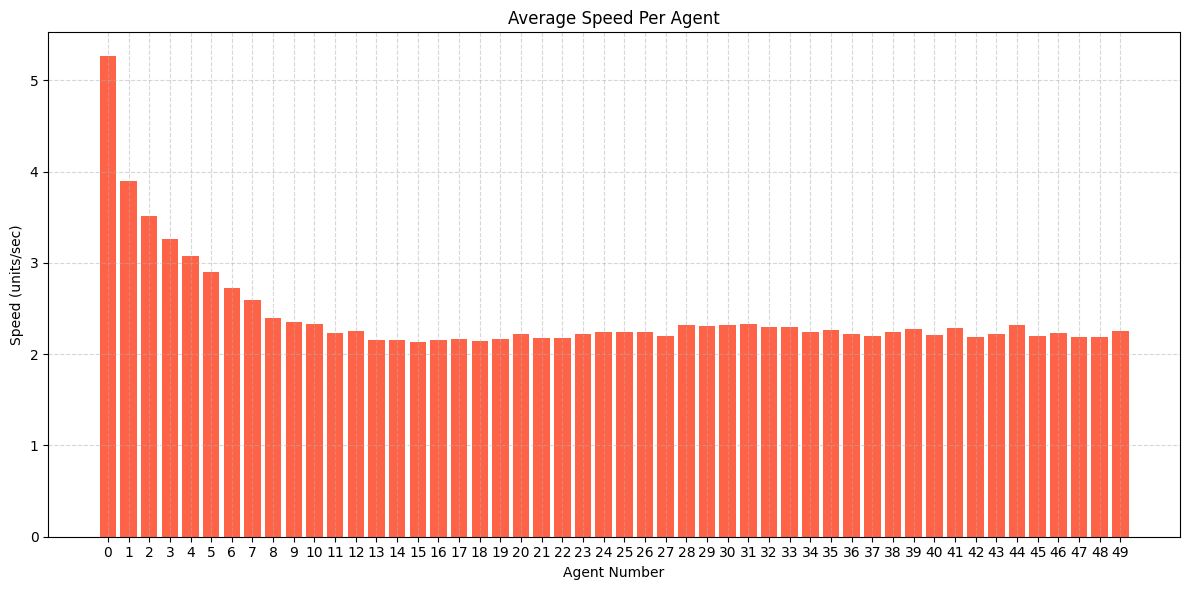

In [10]:
avg_speeds = compute_avg_speed(train_data)
plot_bar(avg_speeds, 'Average Speed Per Agent', 'Speed (units/sec)', 'tomato')


general data


In [11]:
def compute_object_type_frequencies(training_data):
    """
    Returns the total count of each object type across all agents and scenes.
    """
    object_type_data = training_data[:, :, :, 5]  # shape: (10000, 50, 110)
    
    # Only consider first timestep to avoid overcounting the same agent
    first_timestep_types = object_type_data[:, :, 0].astype(int)  # shape: (10000, 50)

    # Flatten and count each object type
    flat_types = first_timestep_types.flatten()
    type_counts = np.bincount(flat_types, minlength=10)  # 10 known types

    return type_counts


In [12]:
object_type_names = [
    'vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus',
    'static', 'background', 'construction', 'riderless_bicycle', 'unknown'
]


In [13]:
def compute_per_type_motion_stats(training_data):
    """
    Returns average speed and acceleration per object type (0–9).
    """
    positions = training_data[:, :, :, :2]
    velocities = training_data[:, :, :, 2:4]
    object_types = training_data[:, :, :, 5].astype(int)  # shape: (10000, 50, 110)

    speed = np.linalg.norm(velocities, axis=-1)  # shape: (10000, 50, 110)
    
    # Acceleration as difference between speeds (frame to frame)
    accel = np.diff(speed, axis=2, prepend=0)  # shape: (10000, 50, 110)

    # Mask padded steps (where x and y == 0)
    valid_mask = np.any(positions != 0, axis=-1)

    type_speeds = [[] for _ in range(10)]
    type_accels = [[] for _ in range(10)]

    for t in range(10):  # For each object type
        type_mask = (object_types == t) & valid_mask  # shape: (10000, 50, 110)
        type_speeds[t] = speed[type_mask]
        type_accels[t] = accel[type_mask]

    avg_speeds_by_type = [np.nanmean(s) if len(s) > 0 else 0 for s in type_speeds]
    avg_accels_by_type = [np.nanmean(a) if len(a) > 0 else 0 for a in type_accels]

    return avg_speeds_by_type, avg_accels_by_type


In [14]:
def plot_by_object_type(values, title, ylabel, color='orchid'):
    object_type_names = [
        'vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus',
        'static', 'background', 'construction', 'riderless_bicycle', 'unknown'
    ]
    plt.figure(figsize=(12, 6))
    plt.bar(object_type_names, values, color=color)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


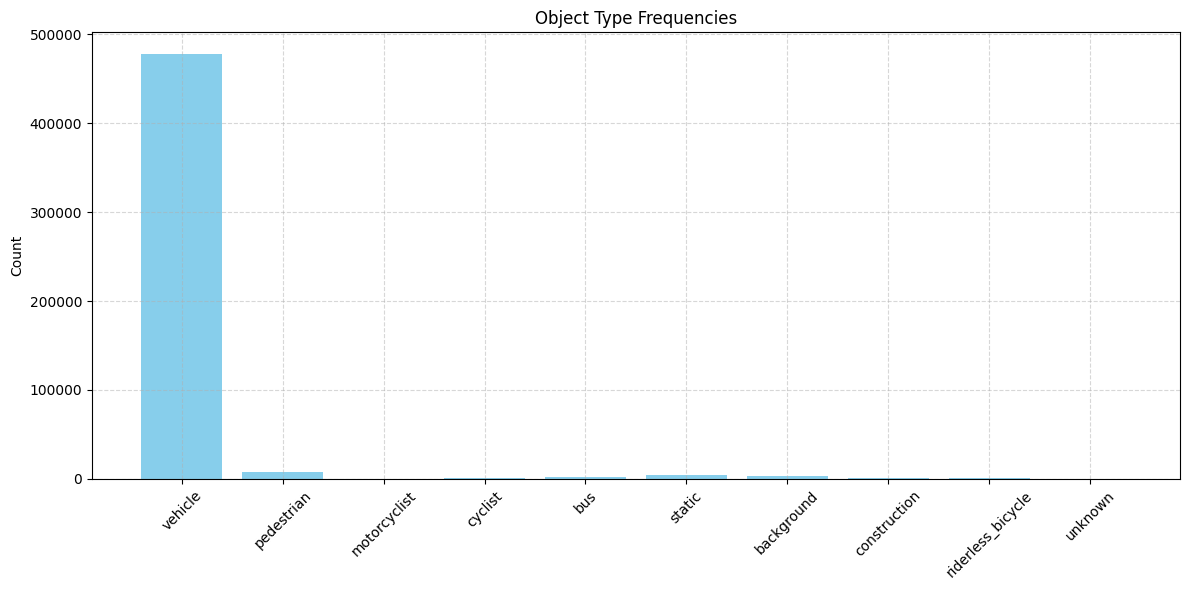

In [15]:
# Object Type Frequencies
type_counts = compute_object_type_frequencies(train_data)
plot_by_object_type(type_counts, 'Object Type Frequencies', 'Count', 'skyblue')

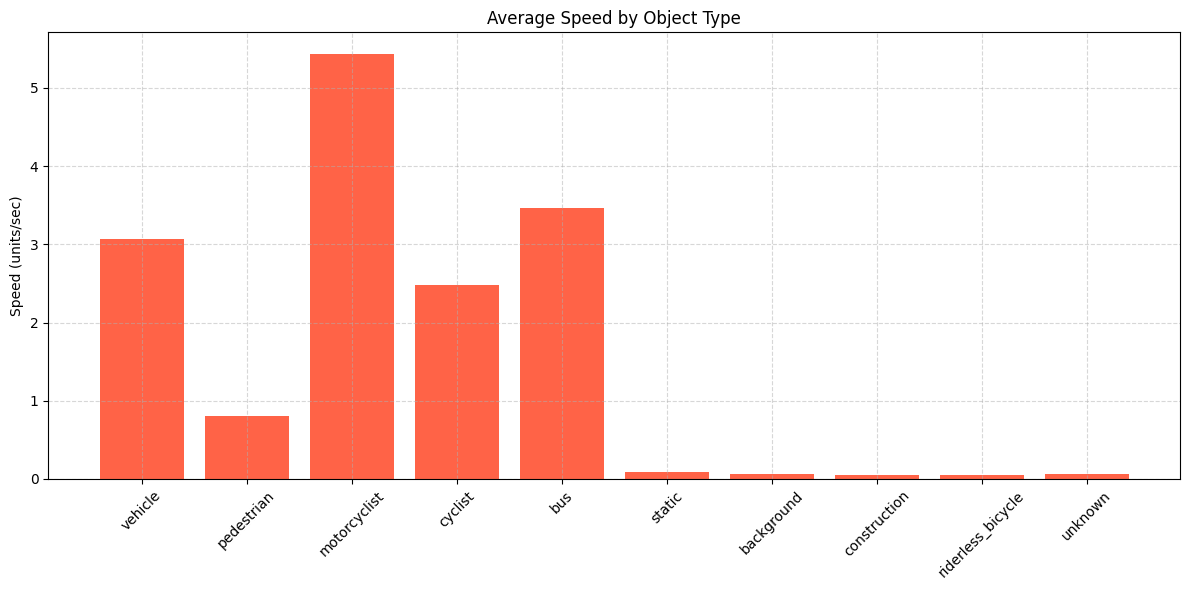

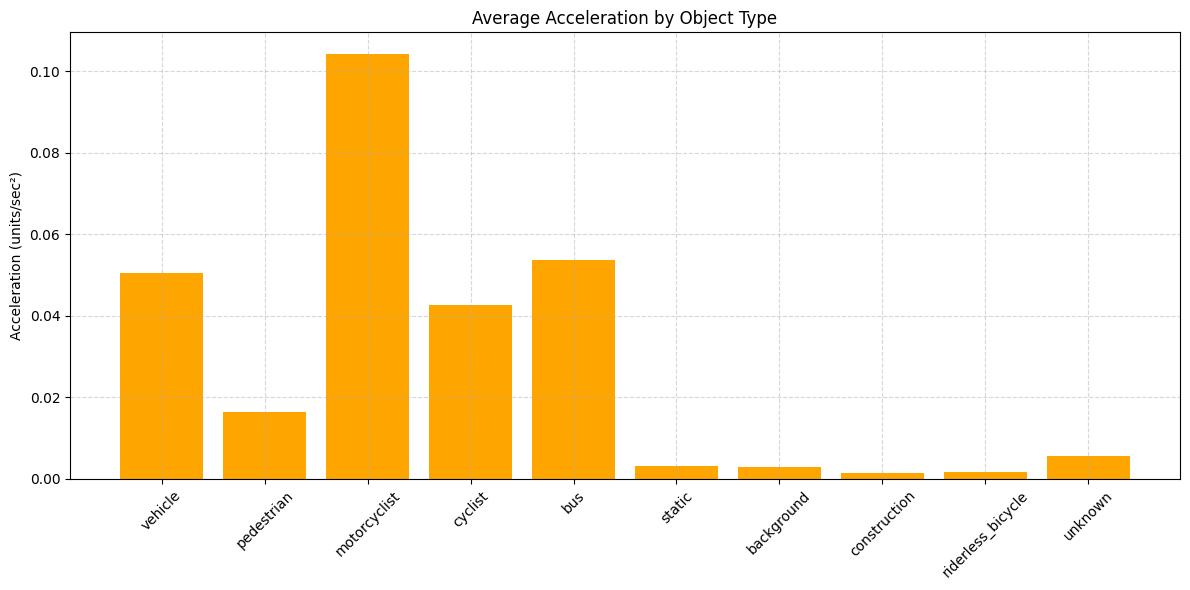

In [16]:
# Per-Type Motion Stats
avg_speeds, avg_accels = compute_per_type_motion_stats(train_data)
plot_by_object_type(avg_speeds, 'Average Speed by Object Type', 'Speed (units/sec)', 'tomato')
plot_by_object_type(avg_accels, 'Average Acceleration by Object Type', 'Acceleration (units/sec²)', 'orange')

how often is ego a vehicle?

In [17]:
def ego_vehicle_ratio(training_data):
    """
    Calculates how often the ego agent (index 0) is a vehicle (object_type == 0).
    Returns (vehicle_count, non_vehicle_count).
    """
    # Extract object type of ego agent at timestep 0
    ego_types = training_data[:, 0, 0, 5].astype(int)  # shape: (10000,)

    # Count how many are type 0 (vehicle)
    vehicle_count = np.sum(ego_types == 0)
    non_vehicle_count = np.sum(ego_types != 0)

    return vehicle_count, non_vehicle_count


In [18]:
vehicle_count, non_vehicle_count = ego_vehicle_ratio(train_data)

print(f"Ego agent is a vehicle in {vehicle_count} out of 10,000 scenes.")
print(f"Ego agent is NOT a vehicle in {non_vehicle_count} out of 10,000 scenes.")
print(f"Percentage vehicle: {vehicle_count / 100:.2f}%")


Ego agent is a vehicle in 10000 out of 10,000 scenes.
Ego agent is NOT a vehicle in 0 out of 10,000 scenes.
Percentage vehicle: 100.00%
